## Inteligență Artificială - Laboratorul 2 : Căutare locală
- Mihai Nan <mihai.nan@upb.ro>
- Andrei Dugăeșescu <andrei.dugaesescu@upb.ro>
- Andrei Olaru <andrei.olaru@upb.ro>

## Scopul laboratorului


*   Familiarizarea cu probleme complexe de căutare în spațiul stărilor
*   Înțelegerea unui algoritm de căutare locală
*   Implementarea a mai multe variante ale algoritmului Hill Climbing și a algoritmului Simulated Annealing
*   Analiza rezultatelor algoritmilor pentru o problemă de căutare în spațiul stărilor


## Problema

Pentru evidențierea rolului strategiilor de căutare locală în spațiul stărilor vom folosi problema damelor.

### Problema damelor

Problema damelor (sau problema reginelor) tratează plasarea a 8 regine de șah pe o tablă de joc de dimensiuni 8 x 8 astfel încat să nu existe două regine care se amenință reciproc.

Două regine se amenința reciproc (sunt în _conflict_) dacă:


*   sunt plasate pe aceeași linie;
*   sunt plasate pe aceeași coloană;
*   sunt plasate pe aceeași diagonală.

Dorim să determinăm o soluție astfel încât nicio pereche de două regine să nu fie pe același rând, pe aceeași coloană, sau pe aceeași diagonală.

O posibilă soluție pentru această problemă este următoarea:

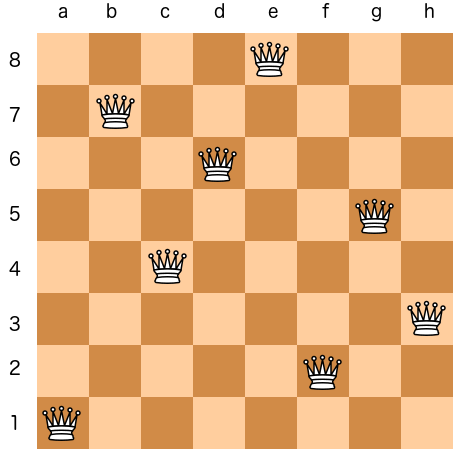

**Observație**: Statea cu opt regine este doar un caz particular pentru problema generală care presupune plasarea a N regine pe o tablă de șah N x N în aceleași condiții.


In [2]:
from __future__ import annotations
from typing import Callable
from copy import copy

import numpy as np
import random

### Definirea problemei

**Reprezentarea soluției**: pentru această problemă soluția este reprezentată de un vector $sol = \left[row_1, row_2, \dots, row_{N}\right]$;

**Domeniul de definiție**: pentru fiecare componentă a vectorului, $row_i$, corespunzătoare unei dame, domeniul este $D_i = \{0, 1, 2, \dots, N-1\}$.

**Observații**: Nu putem plasa două dame pe aceeași coloană, iar numărul de coloane este egal cu numărul de dame.

De aici putem deduce că pe fiecare linie se va afla fix o damă. Astfel, putem presupune că fiecare damă este poziționată pe coloana corespunzătoare indicelui ei, iar în acest mod vom reduce domeniul de definiție la unul unidimensional ($D_i = \{0, 1, 2, \dots, N-1\}$).

În laboratorul de astăzi vom folosi $N=8$.

In [3]:
class State:
    def __init__(
        self, 
        size: int, 
        board: list[int] | None = None, 
        conflicts: int | None = None, 
        seed: int = 42
    ) -> None:
        
        self.size = size
        self.board = board if board is not None else State.generate_board(size, seed)
        self.nconflicts = conflicts if conflicts is not None \
            else State.__compute_conflicts(self.size, self.board)
    
    def apply_move(self, queen: int, new_row: int) -> State:
        '''
        Construiește o stare vecină în care dama queen este mutată pe linia new_row.
        
        Numărul de conflicte este calculat prin diferența față de starea originală.
        '''
        old_row = self.board[queen]
        new_state = copy(self.board)
        new_state[queen] = new_row
        _conflicts = self.nconflicts
        for i in range(self.size):
            if i != queen:
                if self.board[i] == old_row: _conflicts -= 1
                if abs(self.board[i] - old_row) == abs(i - queen): _conflicts -= 1
                if self.board[i] == new_row: _conflicts += 1
                if abs(self.board[i] - new_row) == abs(i - queen): _conflicts += 1
        return State(self.size, new_state, _conflicts)
    
    @staticmethod
    def generate_board(size: int, seed: int) -> list[int]:
        '''
        Construiește o tablă de mărimea dată cu damele poziționate pe rânduri aleatoare.
        '''
        random.seed(seed)
        board = list(range(size))
        random.shuffle(board)

        return board
    
    @staticmethod
    def __compute_conflicts(size: int, board: list[int]) -> int:
        '''
        Calculează numărul de conflicte parcurgând toate perechile de dame
        '''
        _conflicts = 0
        for i in range(size):
            for j in range(i + 1, size):
                if board[i] == board[j]: _conflicts += 1
                if abs(board[i] - board[j]) == (j - i): _conflicts += 1

        return _conflicts
    
    def conflicts(self) -> int:
        '''
        Întoarce numărul de conflicte din această stare.
        '''
        return self.nconflicts
    
    def is_final(self) -> bool:
        '''
        Întoarce True dacă este stare finală.
        '''
        return self.nconflicts == 0
    
    def get_next_states(self) -> list[State]:
        '''
        Întoarce un generator cu toate posibilele stări următoare.
        '''
        return (self.apply_move(col, row) for col in range(self.size)
                for row in range(self.size) if row != self.board[col])
    
    def __str__(self) -> str:
        board = " " + "_ " * self.size + "\n"
        board += "|\n".join("|" + "|".join(("Q" if col == self.board[row] else"_") 
                                            for row in range(self.size)) 
                                            for col in range(self.size))
        board += "|\n"
        return board
    
    def display(self) -> None:
        '''
        Afișează tablei de joc
        '''
        print(self)
    
    def clone(self) -> State:
        '''
        Clonează tabla de joc
        '''
        return State(self.size, copy(self.board), self.nconflicts)

In [4]:
state = State(8, [4, 1, 3, 6, 2, 7, 5, 0])
state.display()
print(f"Number of conflicts: {state.conflicts()}")  # Intoarce 0, este solutie
print(f"Is{'' if state.is_final() else 'not'} solution.\n")

state = State(8, [5, 0, 6, 1, 0, 2, 7, 4])
state.display()
print(f"Number of conflicts: {state.conflicts()}")  # Intoarce 3
print(f"Is {'' if state.is_final() else 'not'} solution.\n")

state = state.apply_move(1, 3) # regina de pe coloana 1 o mutăm pe rândul 3
print(state)
print(f"Number of conflicts: {state.conflicts()}")  # Intoarce 4
print(f"Is {'' if state.is_final() else 'not'} solution.\n")

 _ _ _ _ _ _ _ _ 
|_|_|_|_|_|_|_|Q|
|_|Q|_|_|_|_|_|_|
|_|_|_|_|Q|_|_|_|
|_|_|Q|_|_|_|_|_|
|Q|_|_|_|_|_|_|_|
|_|_|_|_|_|_|Q|_|
|_|_|_|Q|_|_|_|_|
|_|_|_|_|_|Q|_|_|

Number of conflicts: 0
Is solution.

 _ _ _ _ _ _ _ _ 
|_|Q|_|_|Q|_|_|_|
|_|_|_|Q|_|_|_|_|
|_|_|_|_|_|Q|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|Q|
|Q|_|_|_|_|_|_|_|
|_|_|Q|_|_|_|_|_|
|_|_|_|_|_|_|Q|_|

Number of conflicts: 3
Is not solution.

 _ _ _ _ _ _ _ _ 
|_|_|_|_|Q|_|_|_|
|_|_|_|Q|_|_|_|_|
|_|_|_|_|_|Q|_|_|
|_|Q|_|_|_|_|_|_|
|_|_|_|_|_|_|_|Q|
|Q|_|_|_|_|_|_|_|
|_|_|Q|_|_|_|_|_|
|_|_|_|_|_|_|Q|_|

Number of conflicts: 4
Is not solution.



Un algoritm întoarce un tuplu format din:
  * dacă a ajuns la starea finală
  * numărul de iterații pe care le-a realizat (adâncimea la care a ajuns)
  * numărul de stări pe care le-a construit
  * starea finală la care a ajuns înainte de oprire

In [5]:
Result = tuple[bool, int, int, State]
statistics = {}

In [6]:
def run_test(method: Callable, name: str, n_trials: int = 3000, size: int = 8, **kwargs) -> None:
    '''
    Testează un algoritm (method) cu numele name, în n_trials situații initțiale de dimensiune size.
    '''
    wins, fails = 0, 0
    total_iters, total_states, distance = 0, 0, 0
    random.seed(42)
    
    initials = []
    for _ in range(n_trials):
        initials.append(State(size, seed=random.random()))
    
    for initial in initials:
        is_final, iters, states, state = method(initial, **kwargs)
        
        if is_final: 
            wins += 1
            total_iters += iters
            total_states += states
        else:
            fails += 1
            distance += state.conflicts()
    
    padding = ' ' * (30 - len(name))
    win_percentage = (wins / n_trials) * 100.
    print(f"Success rate for {name}: {padding}{wins} / {n_trials} ({win_percentage:.2f}%)")
    if wins > 0: print(f"Average number of iterations (for wins): {' ':8}{(total_iters / wins):.2f}")
    print(f"Total number of states (for wins): {' ':>14}{total_states:,}")
    stat = {
        "wins": win_percentage,
        "iter": total_iters / wins if wins > 0 else 0,
        "nums": total_states
    }
    if fails > 0:
        print(f"Average distance to target (for fails): {' ':>9}{(distance / fails):.2f}")
        stat["dist"] = distance / fails
    statistics[name] = stat

Stategia random alege la întâmplare o regină și o mută pe un rând la întâmplare, diferit de cel inițial.

In [7]:
def random_strategy(initial: State, max_iters: int = 1000):
    iters, states = 0, 0
    state = initial.clone()
    while not state.is_final() and iters < max_iters:
        iters += 1
        col = random.randint(0, initial.size-1)
        row = random.randint(0, initial.size-1)
        if row == state.board[col]: continue
        state = state.apply_move(col, row)
        states += 1
    return state.is_final(), iters, states, state

In [8]:
%time run_test(random_strategy, 'Random') # durează 5-10 secunde

Success rate for Random:                         26 / 3000 (0.87%)
Average number of iterations (for wins):         408.04
Total number of states (for wins):               9,330
Average distance to target (for fails):          7.86
CPU times: total: 18.3 s
Wall time: 19.3 s


## Algoritmul Hill Climbing

Algoritmul Hill Climbing este bazat pe strategia Greedy și este un algoritm de căutare locală.

În cadrul acestui laborator, vom folosi acest algoritm pentru a rezolva problema damelor.

Pornim de la o stare inițială dată și de acolo încercăm să "coborâm" către un minim de constrângeri încălcate.

Fiind un algoritm de căutare locală, nu trebuie să păstrăm arborele de căutare, deoarece nu ne interesează calea pe care trebuie să o parcurgem pentru a ajunge la soluție. În cadrul acestui algoritm, vom opera doar asupra stării curente generând succesori și orientând permanent căutarea în direcția scăderii numărului de constrângeri încălcate. 

Notă: în această problemă încercăm să găsim minimul unei funcții de evaluare, deci termenul de "climbing" este folosit, practic, cu sensul opus.

### Varianta standard


Pentru această variantă, vom avea de implementat următorii pași:

1.   Considerăm starea curentă egală cu starea inițială.
2.   Generăm toate stările succesoare posibile. Folosim funcția ``get_next_states()``
3.   Alegem starea pentru care funcția ``conflicts()``, pe care dorim să o minimizăm, are cea mai mică valoare.
4.   Dacă niciuna dintre stările vecine nu este mai bună decât cea curentă, înseamnă că am atins un minim local, și ne oprim.
5.   Altfel, ne mutăm în starea cea mai bună aleasă și revenim la pasul 2.
6.   Când ne-am oprit, întoarcem un tuplu de 4 componente:
* dacă starea curentă este finală. Folosim funcția ``is_final()``
* numărul total de iterații realizate
* numărul total de stări construite (la fiecare iterație se construiește un număr de stări egal cu numărul de vecini)
* starea în care a ajuns căutarea


In [20]:
def hill_climbing(initial: State, max_iters: int = 1000) -> Result:
    iters, states = 0, 0
    state = initial.clone()
    
    while iters < max_iters:
        iters += 1
        
        # Găsim cea mai bună stare vecină și, 
        # dacă este mai bună decât cea curentă, continuăm din acea stare.
        # Nu uitați să adunați numărul de stări construite.
        next_states = list(state.get_next_states())
        next_state = min(next_states, key=lambda s: s.conflicts())

        states += len(next_states)

        if next_state.conflicts() >= state.conflicts():
            break

        state = next_state
        
    return state.is_final(), iters, states, state
# ne așteptăm cam la 10% căutări cu succes.

In [21]:
%time run_test(hill_climbing, 'Hill Climbing') # durează de ordinul unei secunde

Success rate for Hill Climbing:                  310 / 3000 (10.33%)
Average number of iterations (for wins):         4.58
Total number of states (for wins):               79,464
Average distance to target (for fails):          1.67
CPU times: total: 2.02 s
Wall time: 1.99 s


### Varianta First Choice Hill Climbing

O problemă la Hill Climbing este că evaluăm foarte multe stări vecine. În plus alegerea celei mai abrupte pante (steepest climb) nu este întotdeauna cea mai potrivită, atunci când avem multe minime locale.

Spre deosebire de varianta anterioară, de această dată nu vom mai genera toate stările succesoare posibile, ci ne vom opri în momentul în care am găsit o stare pentru care obținem o valoare mai bună pentru funcția ``conflicts()``.


In [34]:
def first_choice_hill_climbing(initial: State, max_iters: int = 1000) -> Result:
    iters, states = 0, 0
    state = initial.clone()
    
    while iters < max_iters:
        iters += 1
        
        # La fel ca mai sus, dar alegem întotdeauna primul vecin mai bun decât starea curentă.
        # Nu uitați să adunați numărul de stări construite.
        next_states = state.get_next_states()
        next_state = None

        for s in next_states:
            states += 1

            if s.conflicts() < state.conflicts():
                next_state = s
                break

        if next_state is None:
            break
        
        if next_state.conflicts() >= state.conflicts():
            break

        state = next_state
        
    return state.is_final(), iters, states, state
# ne așteptăm cam la 10% căutări cu succes.

In [35]:
%time run_test(first_choice_hill_climbing, 'First Choice Hill Climbing') # durează de ordinul unei secunde

Success rate for First Choice Hill Climbing:     318 / 3000 (10.60%)
Average number of iterations (for wins):         5.45
Total number of states (for wins):               52,300
Average distance to target (for fails):          1.64
CPU times: total: 1.45 s
Wall time: 1.48 s


### Varianta Stochastic Hill Climbing

În această variantă, alegem aleator în care stare următoare să mergem, dintre stările care au numărul de conflicte mai mic decât în starea curentă.


In [38]:
def stochastic_hill_climbing(initial: State, max_iters: int = 1000) -> Result:
    iters, states = 0, 0
    state = initial.clone()
    
    while iters < max_iters:
        iters += 1
        
        # Alegem aleator între vecinii mai buni decât starea curentă.
        # Folosiți radnom.choice(lista)
        # Nu uitați să adunați numărul de stări construite.
        next_states = list(state.get_next_states())
        next_states_filtered = list(filter(lambda s: s.conflicts() < state.conflicts(), next_states))

        states += len(next_states)

        if not next_states_filtered:
            break

        next_state = random.choice(next_states_filtered)

        if next_state.conflicts() >= state.conflicts():
            break

        state = next_state

    return state.is_final(), iters, states, state
# ne așteptăm cam la 12% căutări cu succes.

In [39]:
%time run_test(stochastic_hill_climbing, 'Stochastic Hill Climbing') # durează de ordinul unei secunde

Success rate for Stochastic Hill Climbing:       363 / 3000 (12.10%)
Average number of iterations (for wins):         5.39
Total number of states (for wins):               109,480
Average distance to target (for fails):          1.64
CPU times: total: 3.59 s
Wall time: 3.7 s


### Varianta Random Restart Hill Climbing

Problema de bază a HC este că nu există soluție pentru când ajunge într-un minim local. Spre deosebire de alte tipuri de căutări, nu poate reveni la stări anterioare de pe cale.

În această variantă, atunci când se ajunge la un minim local, se face un _restart_ -- repornim căutarea dintr-o altă stare inițială. Vom avea următorul algoritm:

1.  pornim cu starea inițială
2.  rulăm algoritmul HC din această stare
3.  dacă ajungem într-o stare finală, întoarcem rezultatele
4.  dacă nu am ajuns într-o stare finală, și nu am efectuat până acum mai mult de ``max_restarts``, construim o stare aleatoare (cu ``State(size, seed=random.random())``) și revenim la pasul 2.

In [40]:
def random_restart_hill_climbing(
    initial: State,
    max_restarts: int = 100, 
    run_max_iters: int = 100, 
) -> Result:

    is_final = False
    total_iters, total_states = 0, 0
    
    # Realizăm maximum max_restarts căutări de tip Hill Climbing, din stări aleatoare.
    # Prima dată pornim din starea initial. Pentru stările aleatoare noi, aveți dimensiunea 
    # stării initial în initial.size, și folosiți un seed random
    # Strângem în total_iters și total_states numărul de iterații și stări întors de HC.
    state = initial.clone()

    for _ in range(max_restarts):
        
        is_final, iters, states, state = hill_climbing(state, run_max_iters)
        total_iters += iters
        total_states += states

        if is_final:
            break

        state = State(initial.size, seed=random.random())
    
    return is_final, total_iters, total_states, state
# ne așteptăm la 100% căutări cu succes.

In [41]:
%time run_test(random_restart_hill_climbing, 'Random Restart') # durează cam 10 secunde

Success rate for Random Restart:                 3000 / 3000 (100.00%)
Average number of iterations (for wins):         31.39
Total number of states (for wins):               5,273,912
CPU times: total: 19.4 s
Wall time: 19.4 s


### Simulated Annealing

Simulated annealing este o metodă prin care alegem, dintr-o mulțime de stări următoare, o stare aleatoare, cu o probabilitate corespunzătoare cu calitatea stării. Dacă starea aleasă este mai bună, trecem în acea stare, altfel trecem în ea cu o probabilitate care depinde de diferența dintre stări și de "temperatura" curentă.

"Temperatura" scade cu fiecare iterație, astfel încât devine din ce în ce mai puțin probabil să alegem stări mai proaste decât cea curentă, pe măsură ce ne apropiem de minimul global.

Cât timp nu am ajus la numărul maxim de iterații sau la temperatura finală:
1.  construim stările vecine, punem în lista ``scores`` numărul de conflicte din stările vecine
2.  alegem indexul unei stări folosind o distribuție softmax după numărul de conflicte
3.  dacă vecinul ales este mai bun, mergem în acel vecin
4.  dacă nu, mergem în acel vecin cu probabilitatea $ e^\frac{\Delta}{t \cdot \alpha} $, cu $\Delta$ diferența dintre numărul de conflicte din starea curentă și cel din starea vecină (trebuie să fie negativ).
5.  scădem temperatura conform cu programul de răcire și revenim la pasul 1.

In [17]:
def softmax(x: np.array) -> float:
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [45]:
def simulated_annealing(
    initial: State, 
    t_init: float = 700., 
    t_final: float = 1.,
    cooling: float = 0.995,
    alpha: float = 0.02,
    max_iters: int = 1000
) -> Result:
    
    state = initial.clone()
    t = t_init
    iters, states = 0, 0
    
    while t > t_final and iters < max_iters:
        iters += 1
        if state.is_final():
            break
        
        # Din stările vecine, având numărul de conflicte scores, alegem indexul
        # np.random.choice(len(neighbors), p=softmax(-np.array(scores)))
        #
        # Dacă starea este mai bună, atunci mergem în acea stare.
        #
        # Altfel, mergem în acea stare cu o probabilitate np.exp(delta / (t * alpha))
        # cu delta negativ, diferența dintre numărul de conflicte din starea curentă și din starea vecină
        #
        # Nu uitați să adunați numărul de stări construite.
        next_states = list(state.get_next_states())
        scores = [s.conflicts() for s in next_states]

        states += len(next_states)

        next_state_index = np.random.choice(len(next_states), p=softmax(-np.array(scores)))

        if next_states[next_state_index].conflicts() < state.conflicts():
            state = next_states[next_state_index]

        else:
            delta = next_states[next_state_index].conflicts() - state.conflicts()
            probability = np.exp(delta / (t * alpha))

            if probability >= random.random():
                state = next_states[next_state_index]
        
        t = t * cooling
    
    return state.is_final(), iters, states, state

In [46]:
%time run_test(simulated_annealing, 'Simulated Annealing') # durează de ordinul unui minut

Success rate for Simulated Annealing:            3000 / 3000 (100.00%)
Average number of iterations (for wins):         129.33
Total number of states (for wins):               21,559,944
CPU times: total: 1min 56s
Wall time: 1min 58s


In [47]:
for key in list(statistics.values())[0]:
    keyname = {
        "wins": "Win percentage", 
        "iter": "Average iterations for wins",
        "nums": "Total number of states for wins",
        "dist": "Average conflicts for fails",
    }
    print(f"{keyname[key]}:")
    for method in statistics:
        padding = ' ' * (30 - len(method))
        if key == "nums":
            print(f"    {method}: {padding}{statistics[method].get(key, 0):,}")
        else:
            print(f"    {method}: {padding}{statistics[method].get(key, 0):.2f}")


Win percentage:
    Random:                         0.87
    First Choice Hill Climbing:     10.60
    Stochastic Hill Climbing:       12.10
    Hill Climbing:                  10.33
    Random Restart:                 100.00
    Simulated Annealing:            100.00
Average iterations for wins:
    Random:                         408.04
    First Choice Hill Climbing:     5.45
    Stochastic Hill Climbing:       5.39
    Hill Climbing:                  4.58
    Random Restart:                 31.39
    Simulated Annealing:            129.33
Total number of states for wins:
    Random:                         9,330
    First Choice Hill Climbing:     52,300
    Stochastic Hill Climbing:       109,480
    Hill Climbing:                  79,464
    Random Restart:                 5,273,912
    Simulated Annealing:            21,559,944
Average conflicts for fails:
    Random:                         7.86
    First Choice Hill Climbing:     1.64
    Stochastic Hill Climbing:       1.64
 

Ne așteptăm la rezultate de genul:
```
Win percentage:
    Random:                         0.87
    Hill Climbing:                  10.33
    First Choice Hill Climbing:     10.60
    Stochastic Hill Climbing:       12.10
    Random Restart:                 100.00
    Simulated Annealing:            100.00
Average iterations for wins:
    Random:                         408.04
    Hill Climbing:                  4.58
    First Choice Hill Climbing:     5.45
    Stochastic Hill Climbing:       5.39
    Random Restart:                 31.39
    Simulated Annealing:            120.61
Total number of states for wins:
    Random:                         9,330
    Hill Climbing:                  79,464
    First Choice Hill Climbing:     52,300
    Stochastic Hill Climbing:       109,480
    Random Restart:                 5,273,912
    Simulated Annealing:            20,095,208
Average conflicts for fails:
    Random:                         7.86
    Hill Climbing:                  1.67
    First Choice Hill Climbing:     1.64
    Stochastic Hill Climbing:       1.64
    Random Restart:                 0.00
    Simulated Annealing:            0.00
```